In [16]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap

shap.initjs()

In [5]:
corpus, y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)


In [8]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [25]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence='independent')
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray()

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


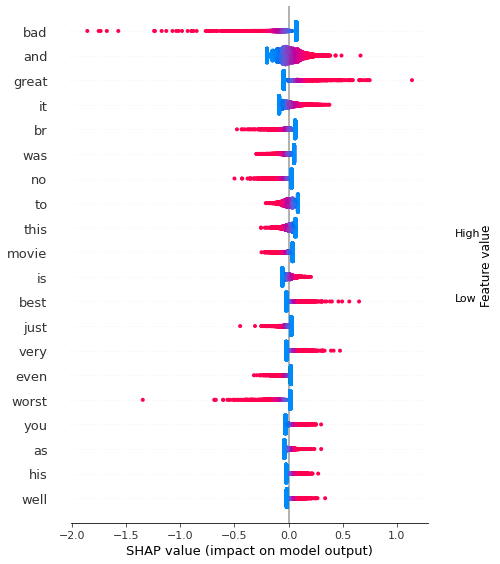

In [13]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())


In [17]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind, :], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [18]:
print(shap.__version__)

0.40.0


In [48]:
import argparse
from audioop import avg
from math import e
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import shap

import torch
from utils import CustomTrainDataset, CustomTestDataset 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from models.NN import NeuralNet

In [49]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc   

In [57]:


# Define hyperparameters
epochs = 10

# Save the trained model
PATH = './pretrained/trained.pth'

#Load clinical data first
df = pd.read_csv('./data/df_onsite.csv')
result_file_name = 'result.csv'

# Separate data into training, validation and testing data
# clinical = df[['age', 'lams', 'nihss', 'time_elapsed', 'Male', 'Female']] 
clinical = df[['age', 'lams', 'time_elapsed', 'Male', 'Female']] # Eliminate the nihss score
features = clinical.columns
label = df['lvo']
clinical_train, clinical_test, label_train, label_test = train_test_split(clinical, label, test_size = 0.2, random_state=42)


# Define the custom dataset

train = CustomTrainDataset(torch.FloatTensor(clinical_train.values), torch.FloatTensor(label_train.values))
test = CustomTestDataset(torch.FloatTensor(clinical_test.values))

# Create DataLoader
trainloader = DataLoader(train, batch_size=4, shuffle=True)
testloader = DataLoader(test, shuffle=False)

# Creat a model
model = NeuralNet()

# Training on GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Create a Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model on training data
model.train() 
for epoch in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for (idx, batch) in enumerate(trainloader):
        inputs, labels = batch[0], batch[1]

        # Cast the data to be in correct format
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        acc = binary_acc(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    print('Epoch {}: | Loss: {} | Acc: {}'.format(epoch, epoch_loss/len(trainloader), epoch_acc/len(trainloader)))

print("Finished training")
torch.save(model.state_dict(), PATH)

# Test the model 

label_pred_list = []
model.eval()
with torch.no_grad():
    for inputs in testloader:
        inputs = inputs.to(device)
        label_test_pred = model(inputs)
        label_pred_tag = torch.round(label_test_pred)
        label_pred_list.append(label_pred_tag.cpu().numpy())

label_pred_list = [a.squeeze().tolist() for a in label_pred_list]

# Classification report

print('Confusion matrix')
print(confusion_matrix(label_test, label_pred_list))

print('Classification report')
print(classification_report(label_test, label_pred_list))

# Accuracy for test set: 85-87%
print('Accuracy report')
print(accuracy_score(label_test, label_pred_list))

# Provide SHAP values
# SHAP values represent a features's responsibility for a change in the model output 
# e = shap.GradientExplainer(model, torch.FloatTensor(clinical_train.values).to(device))
# shap_values = e.shap_values(torch.FloatTensor(clinical_test.values).to(device))
# # print(shap_values)
# x_test_values = clinical_test.to_numpy()
# shap.summary_plot(shap_values, x_test_values, feature_names=features)
# shap.force_plot(e.expected_value, shap_values)
# ind = 0
# shap.force_plot(
#     e.expected_value, shap_values[ind,:], x_test_values[ind,:], features_name=features
# )

# shap.plots.force(shap_values)

print(shap.__version__)
# Provide Grad-Cam
    


cpu
Epoch 1: | Loss: 0.661144160706064 | Acc: 59.43478260869565
Epoch 2: | Loss: 0.6509784550770469 | Acc: 63.391304347826086
Epoch 3: | Loss: 0.6264883253885352 | Acc: 66.65217391304348
Epoch 4: | Loss: 0.6265672639660214 | Acc: 70.65217391304348
Epoch 5: | Loss: 0.6547151907630588 | Acc: 64.1304347826087
Epoch 6: | Loss: 0.6265621729519056 | Acc: 67.3913043478261
Epoch 7: | Loss: 0.6381800278373386 | Acc: 65.95652173913044
Epoch 8: | Loss: 0.6364184229270272 | Acc: 71.0
Epoch 9: | Loss: 0.6761548778285151 | Acc: 58.69565217391305
Epoch 10: | Loss: 0.625966674607733 | Acc: 62.69565217391305
Finished training
Confusion matrix
[[12  2]
 [ 4  5]]
Classification report
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.71      0.56      0.63         9

    accuracy                           0.74        23
   macro avg       0.73      0.71      0.71        23
weighted avg       0.74      0.74      0.73        23

In [58]:
e = shap.DeepExplainer(model, torch.FloatTensor(clinical_train.values).to(device))
shap_values = e.shap_values(torch.FloatTensor(clinical_test.values).to(device))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


RuntimeError: The size of tensor a (64) must match the size of tensor b (128) at non-singleton dimension 1

In [35]:
explainer.expected_value

AttributeError: 'Gradient' object has no attribute 'expected_value'